<a href="https://www.kaggle.com/code/adegbaju/covid-19-forecasting-analysis-using-who-datasets?scriptVersionId=246806204" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install statsmodels
!pip install seaborn
!pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings


2025-06-22 13:17:09.135264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750598229.395438      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750598229.473604      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Importing Data

In [3]:
# Load the CSV file
who_covid_data = pd.read_csv(r"/kaggle/input/worldwide-covid-19-data-from-who/WHO-COVID-19-global-daily-data.csv")

# Display the contents of the dataframe
who_covid_data

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,VC,Saint Vincent and the Grenadines,AMR,NaN,0,NaN,0
1,2020-01-04,SN,Senegal,AFR,NaN,0,NaN,0
2,2020-01-04,SB,Solomon Islands,WPR,0.0,0,0.0,0
3,2020-01-04,LK,Sri Lanka,SEAR,0.0,0,0.0,0
4,2020-01-04,SY,Syrian Arab Republic,EMR,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...
474235,2025-06-01,BR,Brazil,AMR,NaN,37736159,NaN,702875
474236,2025-06-01,BB,Barbados,AMR,NaN,108848,NaN,593
474237,2025-06-01,AZ,Azerbaijan,EUR,NaN,836510,NaN,10353
474238,2025-06-01,BD,Bangladesh,SEAR,3.0,2051706,NaN,29499


The dataset has been loaded successfully. It contains 8 columns and 474,240 rows

# Data Visualization

In [4]:
who_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474240 entries, 0 to 474239
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_reported      474240 non-null  object 
 1   Country_code       472264 non-null  object 
 2   Country            474240 non-null  object 
 3   WHO_region         474240 non-null  object 
 4   New_cases          209350 non-null  float64
 5   Cumulative_cases   474240 non-null  int64  
 6   New_deaths         153502 non-null  float64
 7   Cumulative_deaths  474240 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 28.9+ MB


In [5]:
who_covid_data.describe()

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,2.093500e+05,4.742400e+05,153502.000000,4.742400e+05
mean,3.716504e+03,2.006384e+06,46.233502,2.142356e+04
std,4.867775e+04,8.417441e+06,242.715612,8.606584e+04
min,-6.507900e+04,0.000000e+00,-3520.000000,0.000000e+00
25%,3.000000e+00,6.296000e+03,0.000000,3.800000e+01
50%,6.100000e+01,5.740000e+04,2.000000,6.840000e+02
75%,6.840000e+02,6.438588e+05,15.000000,7.695000e+03
max,6.966046e+06,1.034368e+08,44047.000000,1.224428e+06


In [6]:
# Generate a summary of the COVID-19 data
summary = {
    'total_countries': who_covid_data['Country'].nunique(),
    'total_cases': who_covid_data['Cumulative_cases'].max(),
    'total_deaths': who_covid_data['Cumulative_deaths'].max(),
    'average_new_cases': who_covid_data['New_cases'].mean(),
    'average_new_deaths': who_covid_data['New_deaths'].mean(),
    'most_affected_country_cases': who_covid_data.groupby('Country')['Cumulative_cases'].max().idxmax(),
    'most_affected_country_deaths': who_covid_data.groupby('Country')['Cumulative_deaths'].max().idxmax(),
    'date_range': (who_covid_data['Date_reported'].min(), who_covid_data['Date_reported'].max())
}

summary

{'total_countries': 240,
 'total_cases': 103436829,
 'total_deaths': 1224428,
 'average_new_cases': 3716.5042990207785,
 'average_new_deaths': 46.23350184362419,
 'most_affected_country_cases': 'United States of America',
 'most_affected_country_deaths': 'United States of America',
 'date_range': ('2020-01-04', '2025-06-01')}

The summary of the COVID-19 data is as follows:
- Total countries reported: 240
- Total cumulative cases: 103,436,829
- Total cumulative deaths: 1,224,428
- Average new cases per day: 3,716.50
- Average new deaths per day: 46.23
- Most affected country by cases: United States of America
- Most affected country by deaths: United States of America
- Date range of the data: 2020-01-04 to 2025-06-01

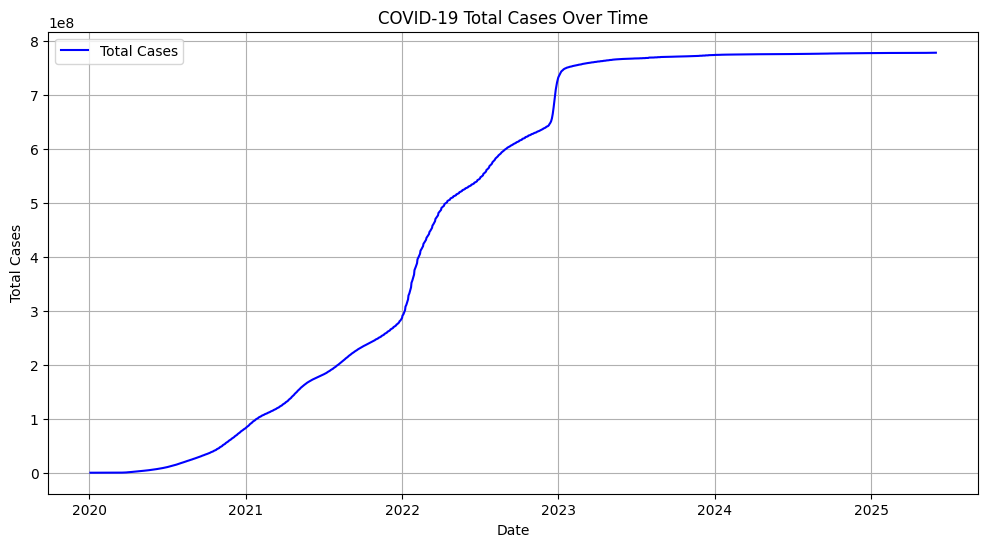

In [7]:


# Convert 'Date_reported' to datetime for proper plotting
who_covid_data['Date_reported'] = pd.to_datetime(who_covid_data['Date_reported'])

# Aggregate data by date for total cases and deaths
daily_totals = who_covid_data.groupby('Date_reported')[['Cumulative_cases', 'Cumulative_deaths']].sum()

# Plot total cases over time
plt.figure(figsize=(12, 6))
plt.plot(daily_totals.index, daily_totals['Cumulative_cases'], label='Total Cases', color='blue')
plt.title('COVID-19 Total Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid()
plt.show()

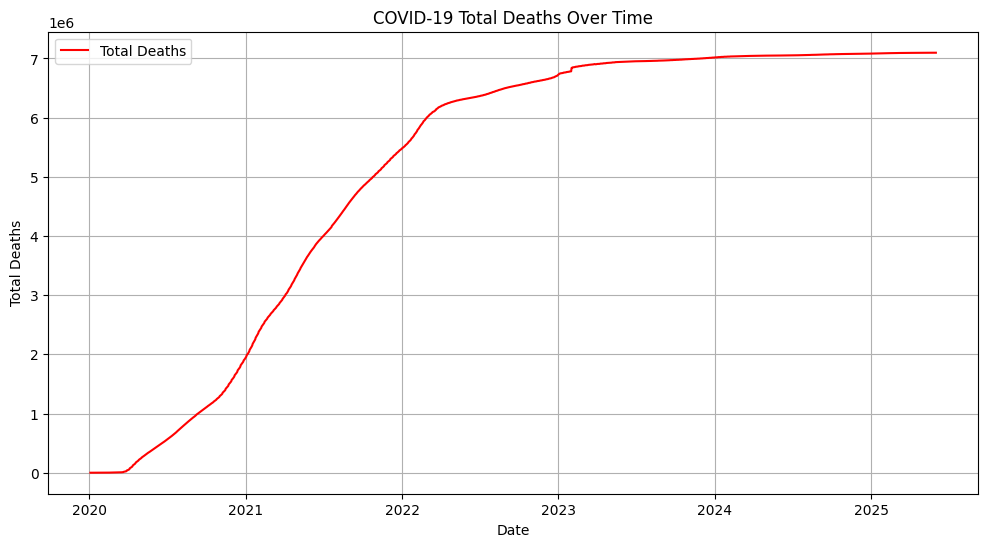

In [8]:
# Plot total deaths over time
plt.figure(figsize=(12, 6))
plt.plot(daily_totals.index, daily_totals['Cumulative_deaths'], label='Total Deaths', color='red')
plt.title('COVID-19 Total Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Aggregate data by country for cumulative cases and deaths
country_comparison = who_covid_data.groupby('Country')[['Cumulative_cases', 'Cumulative_deaths']].max().sort_values(by='Cumulative_cases', ascending=False)

# Display the comparison
df = country_comparison.reset_index()
df

,Country,Cumulative_cases,Cumulative_deaths
0,United States of America,103436829,1224428
1,China,99381761,122398
2,India,45050188,533693
3,France,39039783,168162
4,Germany,38437864,174979
...,...,...,...
235,International conveyance (American Samoa),4,0
236,Pitcairn,4,0
237,International conveyance (Kiribati),2,0
238,Turkmenistan,0,0


# Top 10 Countries by Total COVID-19 Cases and Deaths

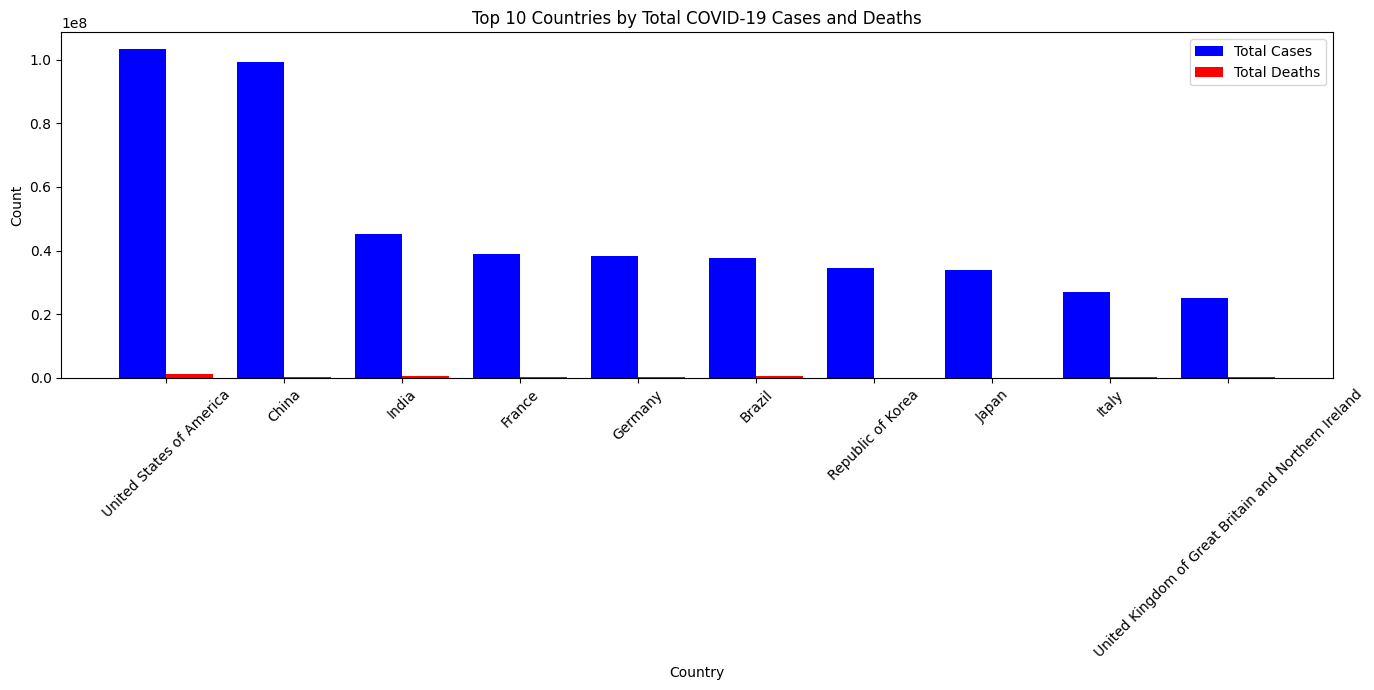

In [10]:
# Generate a bar chart comparing total COVID-19 cases and deaths by country
# Select top 10 countries for better visualization
top_countries = country_comparison.head(10)

# Plot the bar chart
plt.figure(figsize=(14, 7))
bar_width = 0.4
index = range(len(top_countries))

plt.bar(index, top_countries['Cumulative_cases'], bar_width, label='Total Cases', color='blue')
plt.bar([i + bar_width for i in index], top_countries['Cumulative_deaths'], bar_width, label='Total Deaths', color='red')

plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 10 Countries by Total COVID-19 Cases and Deaths')
plt.xticks([i + bar_width / 2 for i in index], top_countries.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Daily New COVID-19 Cases Over Time

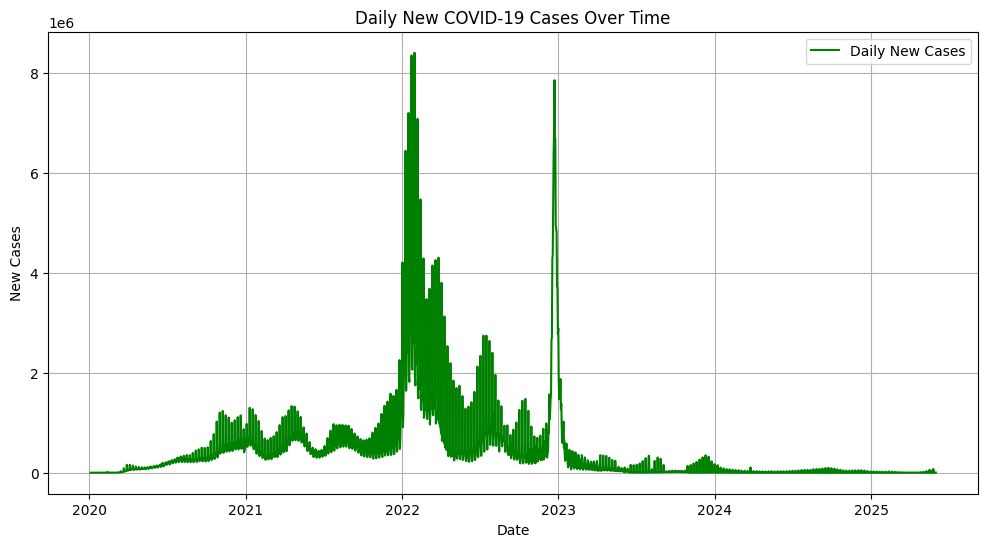

In [11]:
# Aggregate daily new cases over time
daily_new_cases = who_covid_data.groupby('Date_reported')['New_cases'].sum()

# Plot daily new cases over time
plt.figure(figsize=(12, 6))
plt.plot(daily_new_cases.index, daily_new_cases, label='Daily New Cases', color='green')
plt.title('Daily New COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.grid()
plt.show()

# Heatmap For Top 20 Countries

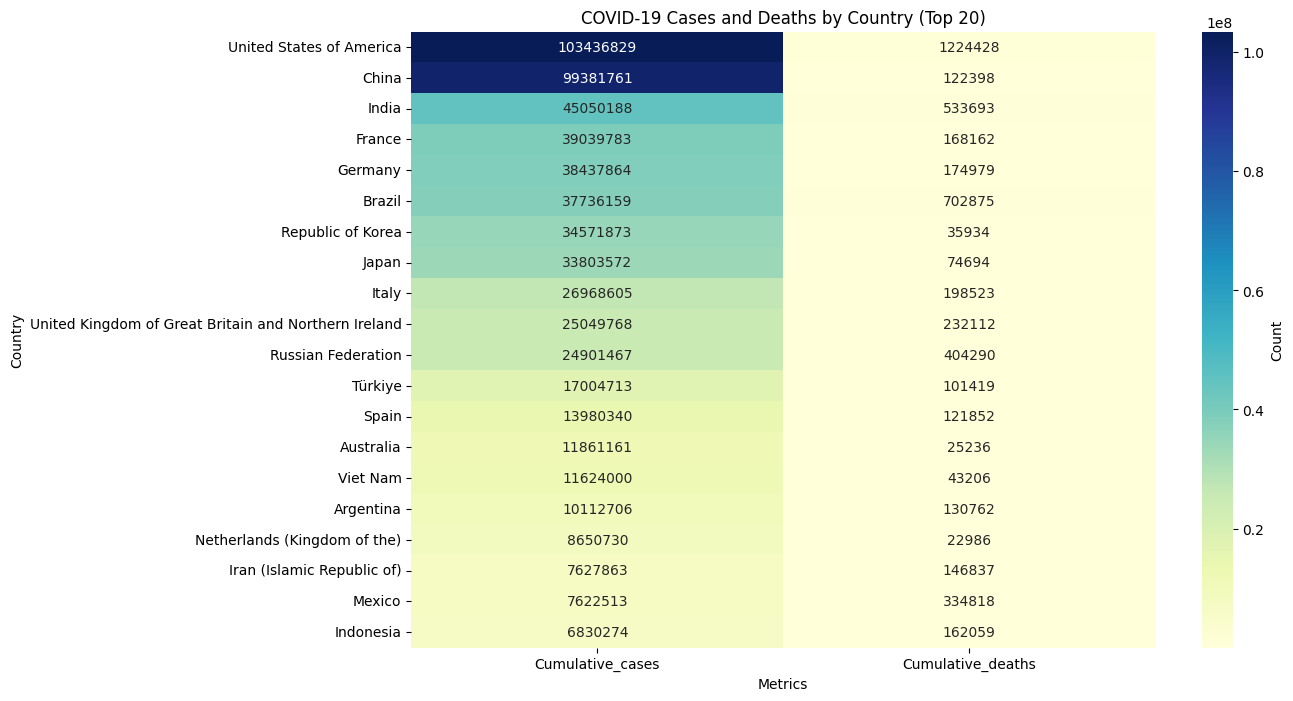

In [12]:


# Prepare data for heatmap
heatmap_data = country_comparison.head(20)  # Select top 20 countries for better visualization

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Count'})
plt.title('COVID-19 Cases and Deaths by Country (Top 20)')
plt.xlabel('Metrics')
plt.ylabel('Country')
plt.show()

# Daily New COVID-19 Cases and Deaths in United States of America

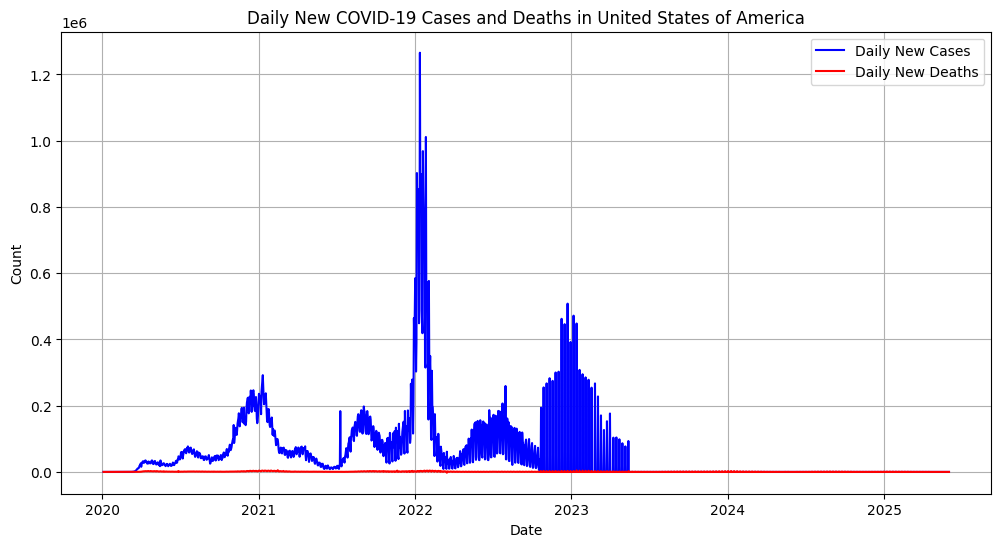

In [13]:
# Filter the dataset for a specific country
country_data = who_covid_data[who_covid_data['Country'] == 'United States of America']

# Aggregate daily new cases and deaths for the specific country
daily_country_data = country_data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum()

# Plot daily new cases and deaths for the specific country
plt.figure(figsize=(12, 6))
plt.plot(daily_country_data.index, daily_country_data['New_cases'], label='Daily New Cases', color='blue')
plt.plot(daily_country_data.index, daily_country_data['New_deaths'], label='Daily New Deaths', color='red')
plt.title('Daily New COVID-19 Cases and Deaths in United States of America')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()

# Daily New COVID-19 Cases and Deaths in China

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


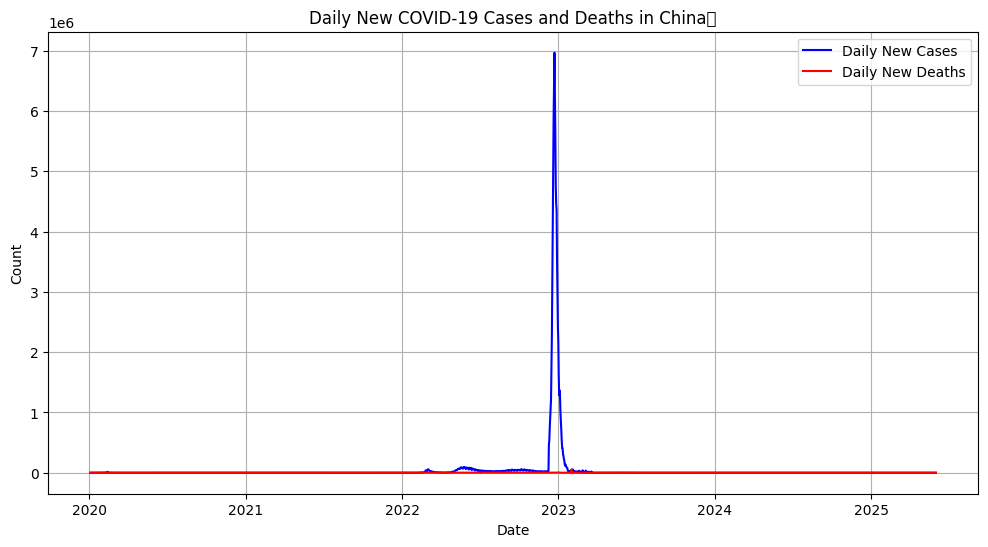

In [14]:
# Filter the dataset for a specific country
country_data = who_covid_data[who_covid_data['Country'] == 'China']

# Aggregate daily new cases and deaths for the specific country
daily_country_data = country_data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum()

# Plot daily new cases and deaths for the specific country
plt.figure(figsize=(12, 6))
plt.plot(daily_country_data.index, daily_country_data['New_cases'], label='Daily New Cases', color='blue')
plt.plot(daily_country_data.index, daily_country_data['New_deaths'], label='Daily New Deaths', color='red')
plt.title('Daily New COVID-19 Cases and Deaths in China	')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()

# Daily New COVID-19 Cases and Deaths in India

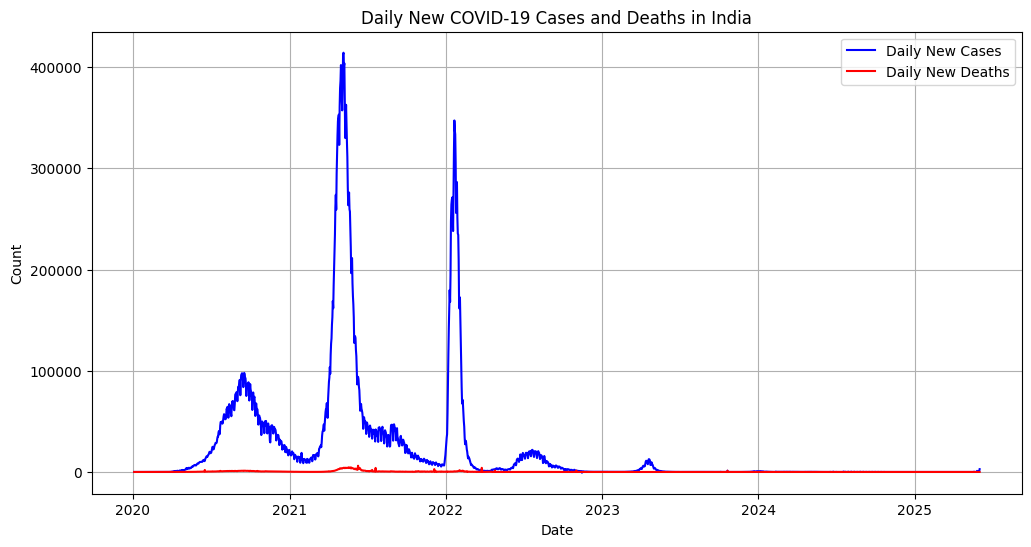

In [15]:
# Filter the dataset for a specific country
country_data = who_covid_data[who_covid_data['Country'] == 'India']

# Aggregate daily new cases and deaths for the specific country
daily_country_data = country_data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum()

# Plot daily new cases and deaths for the specific country
plt.figure(figsize=(12, 6))
plt.plot(daily_country_data.index, daily_country_data['New_cases'], label='Daily New Cases', color='blue')
plt.plot(daily_country_data.index, daily_country_data['New_deaths'], label='Daily New Deaths', color='red')
plt.title('Daily New COVID-19 Cases and Deaths in India')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.show()

# Handling Missing Values

In [16]:
# Print to check if missing data is replaced
print("Missing values in 'New_cases':", who_covid_data['New_cases'].isnull().sum())
print("Missing values in 'New_deaths':", who_covid_data['New_deaths'].isnull().sum())

Missing values in 'New_cases': 264890
Missing values in 'New_deaths': 320738


In [17]:
# Impute missing daily counts via interpolation
who_covid_data['New_cases'] = who_covid_data['New_cases'].interpolate(method='linear')
who_covid_data['New_deaths'] = who_covid_data['New_deaths'].interpolate(method='linear')

In [18]:
# Compute 7-day and 14-day moving averages for new cases and deaths
daily_totals['7_day_avg_cases'] = daily_totals['Cumulative_cases'].rolling(window=7).mean()
daily_totals['14_day_avg_cases'] = daily_totals['Cumulative_cases'].rolling(window=14).mean()
daily_totals['7_day_avg_deaths'] = daily_totals['Cumulative_deaths'].rolling(window=7).mean()
daily_totals['14_day_avg_deaths'] = daily_totals['Cumulative_deaths'].rolling(window=14).mean()

In [19]:
# Create lag features for cases (casesₜ₋₁,…,casesₜ₋₇)
for lag in range(1, 8):
    daily_totals[f'cases_t-{lag}'] = daily_totals['Cumulative_cases'].shift(lag)

# Check if vaccination data is available to incorporate as an exogenous variable
if 'vaccination_data' in globals():
    # Ensure 'Date_reported' is datetime for merging
    vaccination_data['Date_reported'] = pd.to_datetime(vaccination_data['Date_reported'])

    # Aggregate vaccination data by date
    vaccination_totals = vaccination_data.groupby('Date_reported')[['New_cases', 'New_deaths']].sum()

    # Merge vaccination data with daily_totals
    daily_totals = daily_totals.merge(vaccination_totals, left_index=True, right_index=True, how='left', suffixes=('', '_vaccination'))

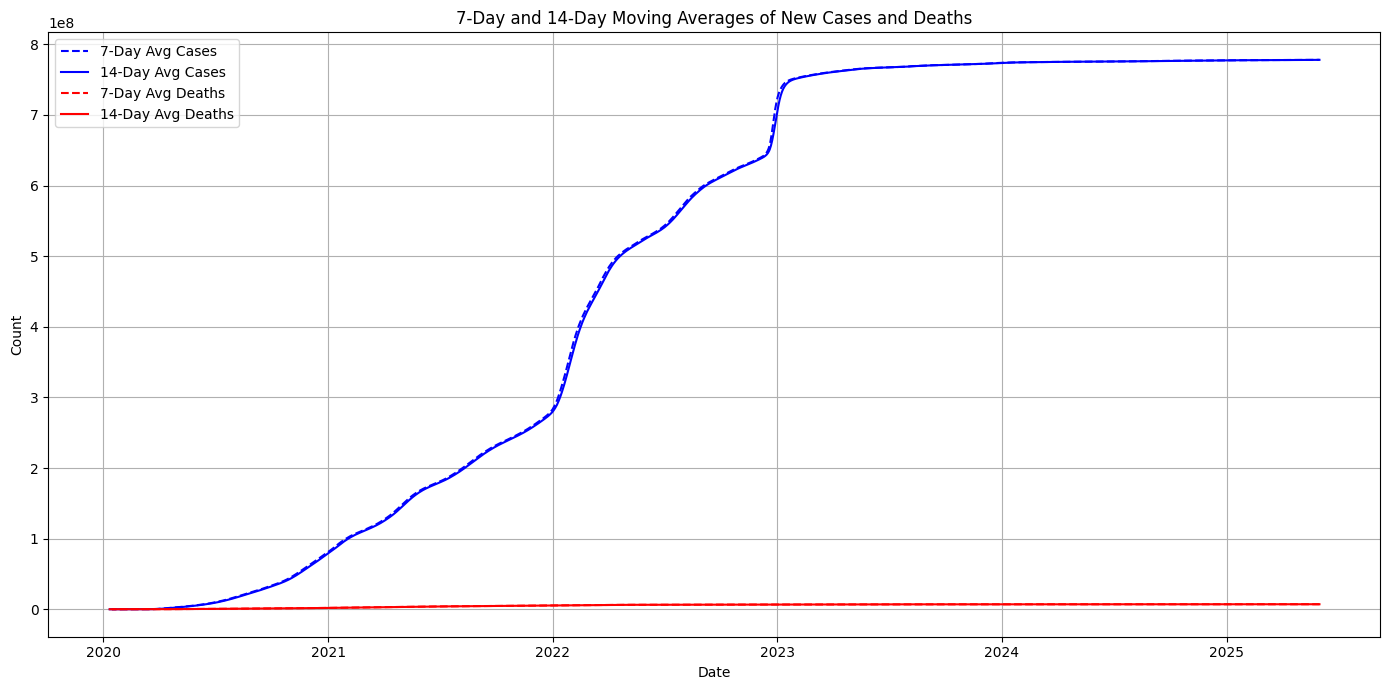

In [20]:
# Plot the 7-day and 14-day moving averages of new cases and deaths
plt.figure(figsize=(14, 7))

# Plot moving averages for new cases
plt.plot(daily_totals.index, daily_totals['7_day_avg_cases'], label='7-Day Avg Cases', color='blue', linestyle='--')
plt.plot(daily_totals.index, daily_totals['14_day_avg_cases'], label='14-Day Avg Cases', color='blue')

# Plot moving averages for new deaths
plt.plot(daily_totals.index, daily_totals['7_day_avg_deaths'], label='7-Day Avg Deaths', color='red', linestyle='--')
plt.plot(daily_totals.index, daily_totals['14_day_avg_deaths'], label='14-Day Avg Deaths', color='red')

plt.title('7-Day and 14-Day Moving Averages of New Cases and Deaths')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Epidemic Curves by WHO Region

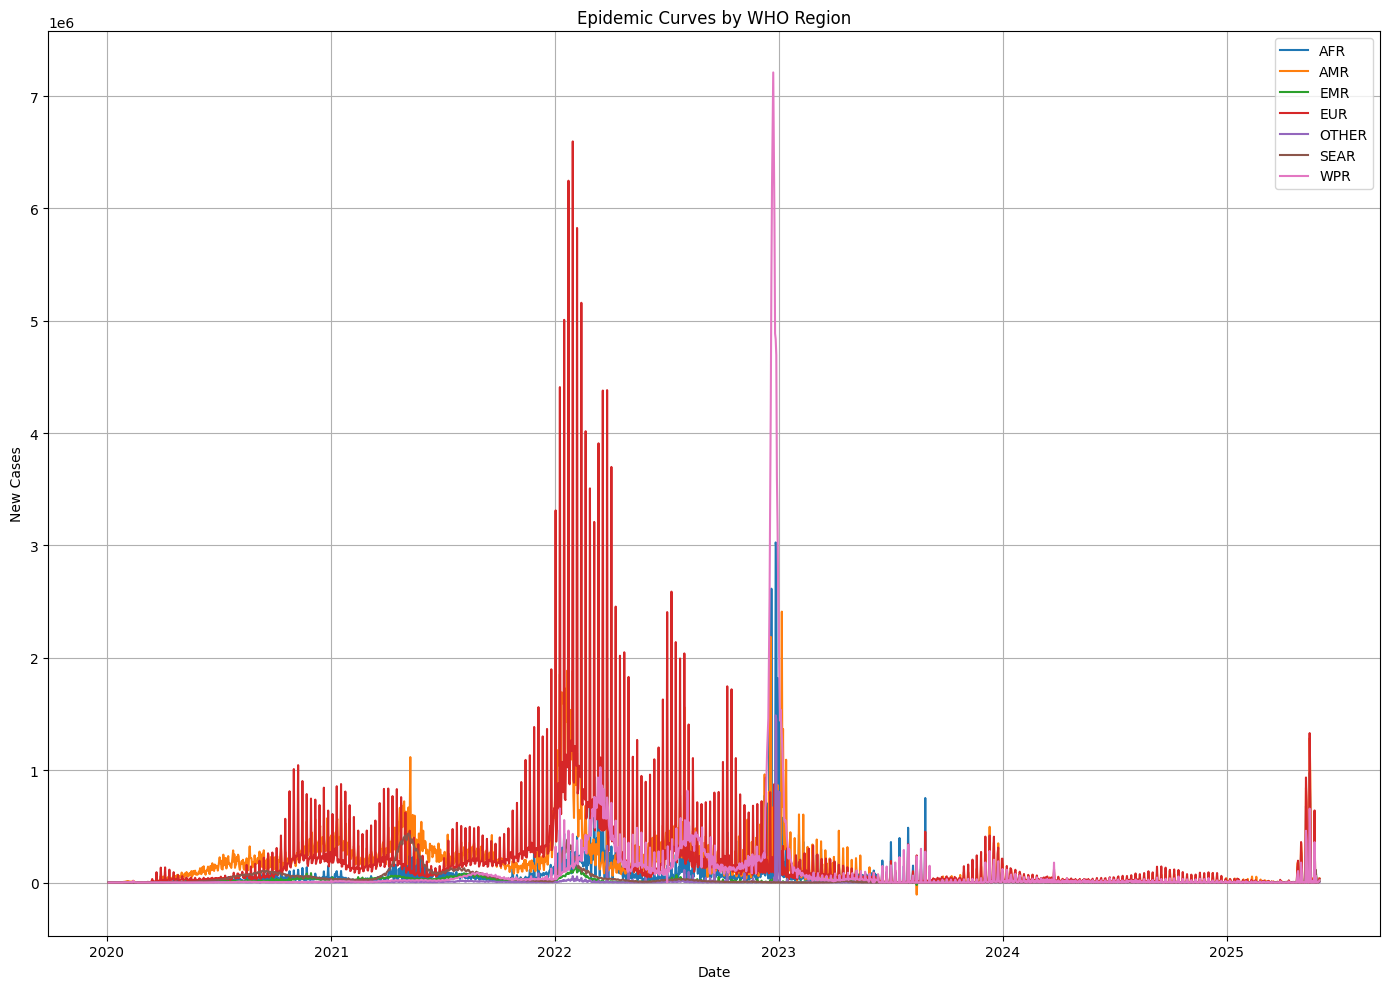

In [21]:
# Aggregate data by region and date for new cases
region_data = who_covid_data.groupby(['WHO_region', 'Date_reported'])['New_cases'].sum().reset_index()

# Plot epidemic curves for each region
regions = region_data['WHO_region'].unique()
plt.figure(figsize=(14, 10))

for region in regions:
    region_curve = region_data[region_data['WHO_region'] == region]
    plt.plot(region_curve['Date_reported'], region_curve['New_cases'], label=region)

plt.title('Epidemic Curves by WHO Region')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller

In [22]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on raw series (Cumulative_cases)
adf_raw = adfuller(daily_totals['Cumulative_cases'].dropna())

# Difference the series and perform the test again
differenced_series = daily_totals['Cumulative_cases'].diff().dropna()
adf_diff = adfuller(differenced_series)

adf_raw, adf_diff

((-1.5623465388443145,
  0.5024753407557995,
  26,
  1949,
  {'1%': -3.433709637523333,
   '5%': -2.863024085652552,
   '10%': -2.567560067343214},
  51502.76263783569),
 (-4.5340538294022315,
  0.00017057968000282935,
  25,
  1949,
  {'1%': -3.433709637523333,
   '5%': -2.863024085652552,
   '10%': -2.567560067343214},
  51477.834689387215))

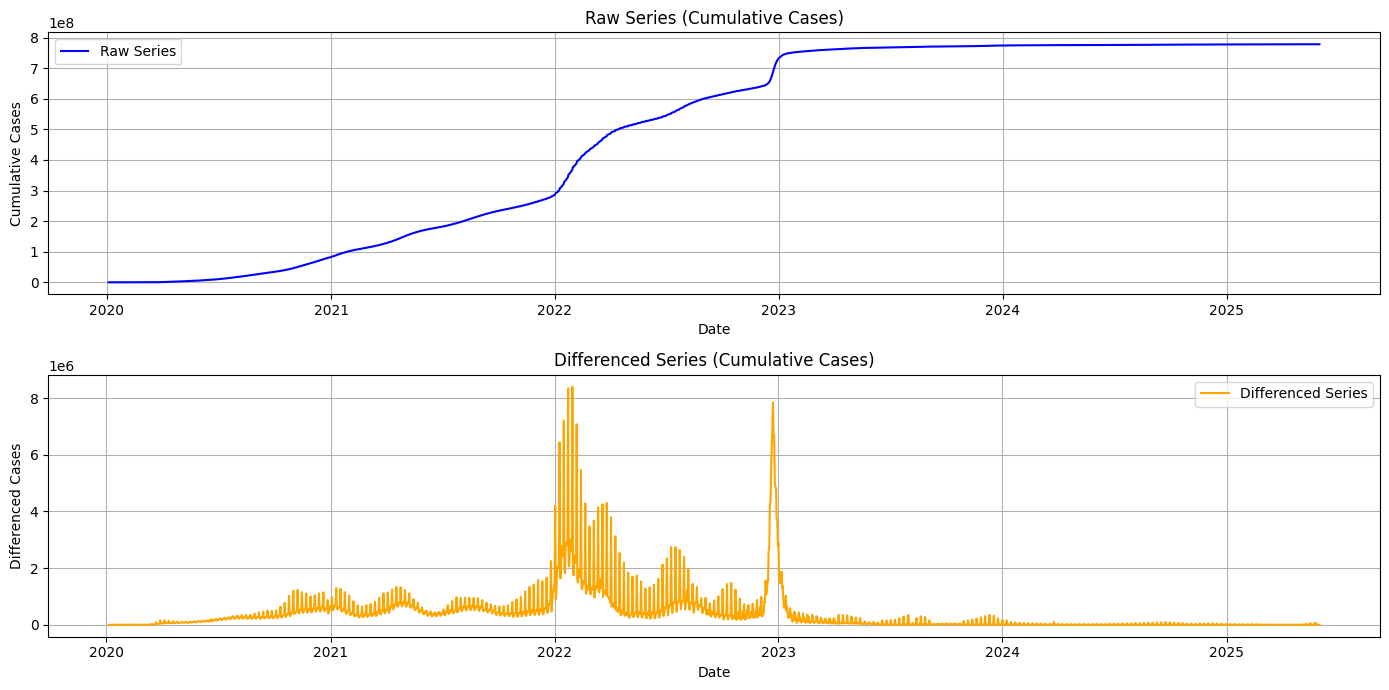

In [23]:
# Visualize the raw and differenced series
plt.figure(figsize=(14, 7))

# Plot raw series
plt.subplot(2, 1, 1)
plt.plot(daily_totals.index, daily_totals['Cumulative_cases'], label='Raw Series', color='blue')
plt.title('Raw Series (Cumulative Cases)')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.grid()

# Plot differenced series
plt.subplot(2, 1, 2)
plt.plot(differenced_series.index, differenced_series, label='Differenced Series', color='orange')
plt.title('Differenced Series (Cumulative Cases)')
plt.xlabel('Date')
plt.ylabel('Differenced Cases')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

The Augmented Dickey-Fuller test results indicate that the raw series is non-stationary (p-value > 0.05), while the differenced series is stationary (p-value < 0.05).

# Auto correlation Function

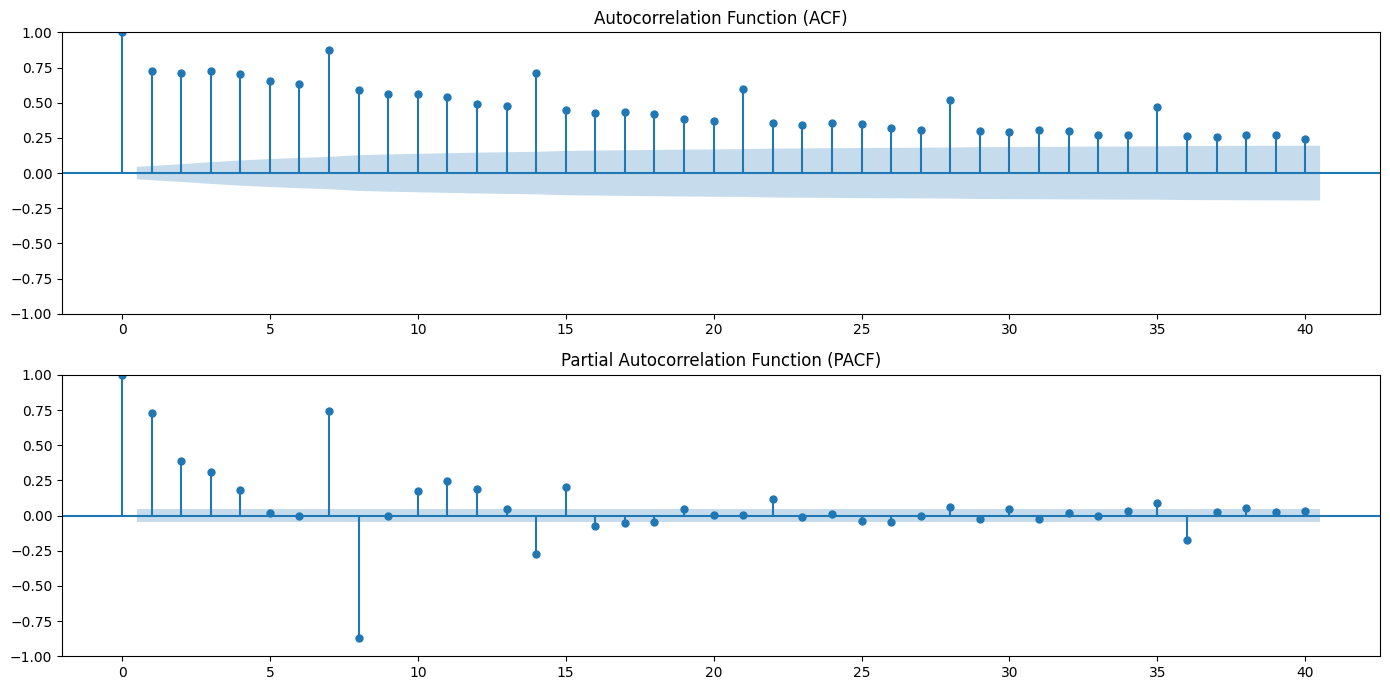

In [24]:


# Plot ACF and PACF for the differenced series
plt.figure(figsize=(14, 7))

# Plot ACF
plt.subplot(2, 1, 1)
plot_acf(differenced_series, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(2, 1, 2)
plot_pacf(differenced_series, ax=plt.gca(), lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Training ARIMA with Forecasting

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define the range of p, d, q, P, D, Q, and s
p = d = q = range(0, 2)  # Reduced range to speed up computation
P = D = Q = range(0, 2)
s_values = [7]  # Focus on weekly seasonality to simplify


# Generate all possible combinations of p, d, q, P, D, Q, and s
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q) for s in s_values]

# Initialize variables to store the best model and its AIC
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Iterate over all combinations of pdq and seasonal_pdq
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            # Fit SARIMA model
            model = SARIMAX(daily_totals['Cumulative_cases'].dropna(), 
                            order=order, 
                            seasonal_order=seasonal_order, 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            # Check if the current model has the lowest AIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model_fit
        except Exception as e:
            continue

# Print the best model orders and AIC
print(f"Best SARIMA model order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")
print(f"Best AIC: {best_aic}")

# Forecast the next 30 days using the best model
forecast = best_model.forecast(steps=30)
print(forecast)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Best SARIMA model order: (1, 1, 1)
Best seasonal order: (1, 1, 1, 7)
Best AIC: 52337.44437549223
2025-06-02    7.781482e+08
2025-06-03    7.781769e+08
2025-06-04    7.781837e+08
2025-06-05    7.781899e+08
2025-06-06    7.781961e+08
2025-06-07    7.781913e+08
2025-06-08    7.781992e+08
2025-06-09    7.783088e+08
2025-06-10    7.783439e+08
2025-06-11    7.783554e+08
2025-06-12    7.783658e+08
2025-06-13    7.783758e+08
2025-06-14    7.783702e+08
2025-06-15    7.783814e+08
2025-06-16    7.784969e+08
2025-06-17    7.785356e+08
2025-06-18    7.785500e+08
2025-06-19    7.785629e+08
2025-06-20    7.785753e+08
2025-06-21    7.785701e+08
2025-06-22    7.785832e+08
2025-06-23    7.787016e+08
2025-06-24    7.787423e+08
2025-06-25    7.787583e+08
2025-06-26    7.787727e+08
2025-06-27    7.787864e+08
2025-06-28    7.787816e+08
2025-06-29    7.787959e+08
2025-06-30    7.789157e+08
2025-07-01    7.789575e+08
Freq: D, Name: predicted_mean, dtype: float64


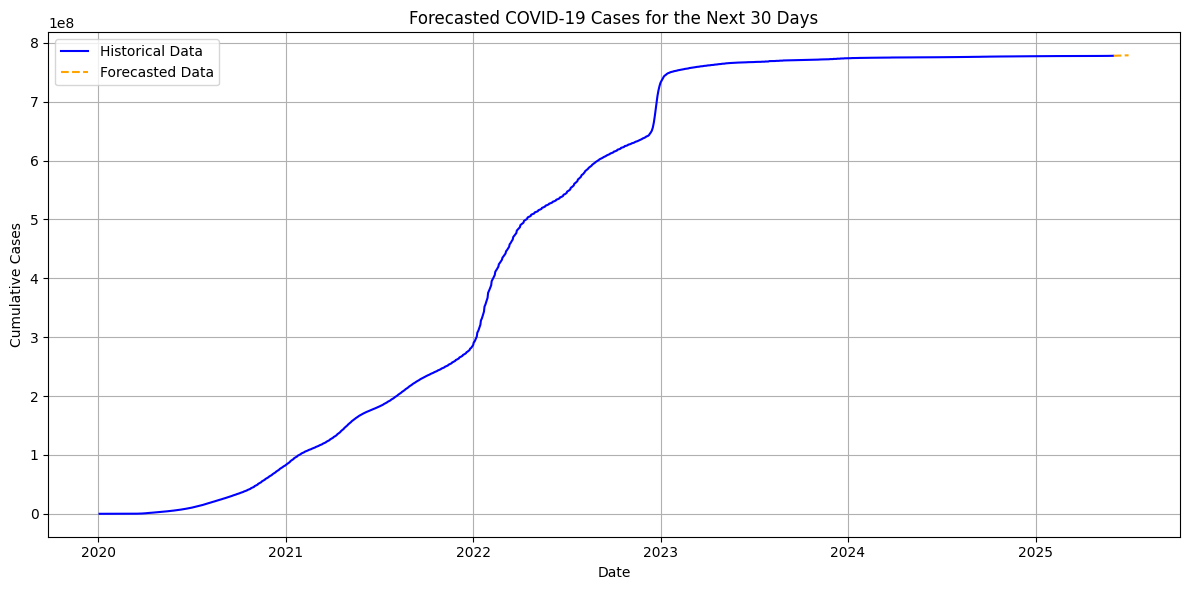

In [26]:
# Visualize the forecasted COVID-19 cases for the next 30 days
plt.figure(figsize=(12, 6))

# Plot the historical data
plt.plot(daily_totals.index, daily_totals['Cumulative_cases'], label='Historical Data', color='blue')

# Plot the forecasted data
forecast_index = pd.date_range(start=daily_totals.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
plt.plot(forecast_index, forecast, label='Forecasted Data', color='orange', linestyle='--')

plt.title('Forecasted COVID-19 Cases for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Training Prophet for the Next 30 Days Forecasting

In [27]:


# Prepare data for Prophet
prophet_data = daily_totals.reset_index()[['Date_reported', 'Cumulative_cases']]
prophet_data.columns = ['ds', 'y']  # Rename columns for Prophet

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Create a dataframe for future dates
future_dates = prophet_model.make_future_dataframe(periods=30)

# Forecast the future
forecast = prophet_model.predict(future_dates)
forecast

13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-04,-5.524467e+06,-1.108363e+07,3.549044e+06,-5.524467e+06,-5.524467e+06,1.993896e+06,1.993896e+06,1.993896e+06,-159300.079891,-159300.079891,-159300.079891,2.153197e+06,2.153197e+06,2.153197e+06,0.0,0.0,0.0,-3.530571e+06
1,2020-01-05,-5.445619e+06,-1.026788e+07,4.596621e+06,-5.445619e+06,-5.445619e+06,2.717259e+06,2.717259e+06,2.717259e+06,233402.998098,233402.998098,233402.998098,2.483856e+06,2.483856e+06,2.483856e+06,0.0,0.0,0.0,-2.728360e+06
2,2020-01-06,-5.366771e+06,-1.031778e+07,4.820688e+06,-5.366771e+06,-5.366771e+06,2.934707e+06,2.934707e+06,2.934707e+06,153752.855018,153752.855018,153752.855018,2.780954e+06,2.780954e+06,2.780954e+06,0.0,0.0,0.0,-2.432064e+06
3,2020-01-07,-5.287923e+06,-9.687161e+06,5.239384e+06,-5.287923e+06,-5.287923e+06,3.071891e+06,3.071891e+06,3.071891e+06,27673.495548,27673.495548,27673.495548,3.044218e+06,3.044218e+06,3.044218e+06,0.0,0.0,0.0,-2.216032e+06
4,2020-01-08,-5.209075e+06,-1.019497e+07,5.226077e+06,-5.209075e+06,-5.209075e+06,3.234767e+06,3.234767e+06,3.234767e+06,-39231.592232,-39231.592232,-39231.592232,3.273998e+06,3.273998e+06,3.273998e+06,0.0,0.0,0.0,-1.974308e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001,2025-06-27,7.783613e+08,7.683529e+08,7.840838e+08,7.768724e+08,7.789467e+08,-1.892189e+06,-1.892189e+06,-1.892189e+06,-122474.551064,-122474.551064,-122474.551064,-1.769714e+06,-1.769714e+06,-1.769714e+06,0.0,0.0,0.0,7.764691e+08
2002,2025-06-28,7.783683e+08,7.682285e+08,7.839348e+08,7.767387e+08,7.790623e+08,-1.936428e+06,-1.936428e+06,-1.936428e+06,-159300.079890,-159300.079890,-159300.079890,-1.777128e+06,-1.777128e+06,-1.777128e+06,0.0,0.0,0.0,7.764318e+08
2003,2025-06-29,7.783752e+08,7.685056e+08,7.854509e+08,7.766258e+08,7.791773e+08,-1.549002e+06,-1.549002e+06,-1.549002e+06,233402.998098,233402.998098,233402.998098,-1.782405e+06,-1.782405e+06,-1.782405e+06,0.0,0.0,0.0,7.768262e+08
2004,2025-06-30,7.783821e+08,7.684863e+08,7.852489e+08,7.764809e+08,7.793131e+08,-1.632189e+06,-1.632189e+06,-1.632189e+06,153752.855018,153752.855018,153752.855018,-1.785942e+06,-1.785942e+06,-1.785942e+06,0.0,0.0,0.0,7.767499e+08


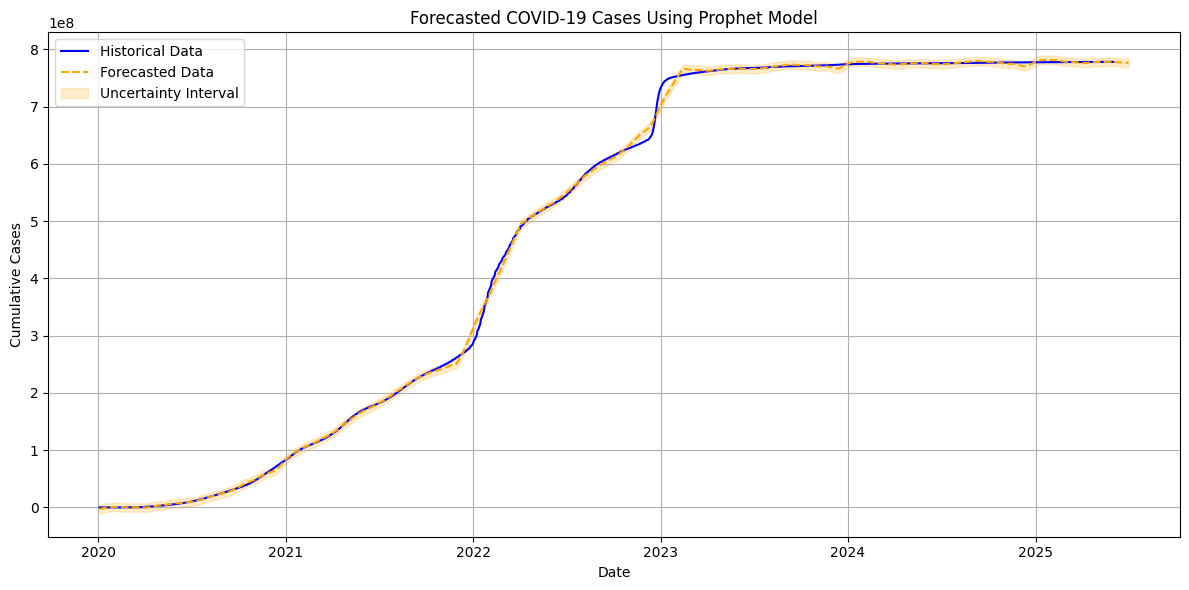

In [28]:
# Visualize the forecasted COVID-19 cases using the Prophet model
plt.figure(figsize=(12, 6))

# Plot the historical data
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Data', color='blue')

# Plot the forecasted data
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Data', color='orange', linestyle='--')

# Highlight the uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Uncertainty Interval')

plt.title('Forecasted COVID-19 Cases Using Prophet Model')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Univariate Time Series Forecasting for LSTM

In [29]:


# Prepare the data for LSTM
# Use the 'Cumulative_cases' column for univariate time series forecasting
cases = daily_totals['Cumulative_cases'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
cases_scaled = scaler.fit_transform(cases)

# Create sliding windows of size 14
window_size = 14
X, y = [], []
for i in range(len(cases_scaled) - window_size):
    X.append(cases_scaled[i:i + window_size, 0])
    y.append(cases_scaled[i + window_size, 0])
X, y = np.array(X), np.array(y)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))  # Apply 20% dropout
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20


2025-06-22 13:18:34.247630: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2987 - val_loss: 0.0155
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0183 - val_loss: 0.0011
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0105 - val_loss: 0.0036
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0110 - val_loss: 2.4927e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0098 - val_loss: 6.0439e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0100 - val_loss: 2.0809e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0111 - val_loss: 2.1368e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0108 - val_loss: 3.0445e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0089 - val_loss: 5.7698e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0094 - val_loss: 1.5030e-05
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0083 - val_loss: 1.5357e-04
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


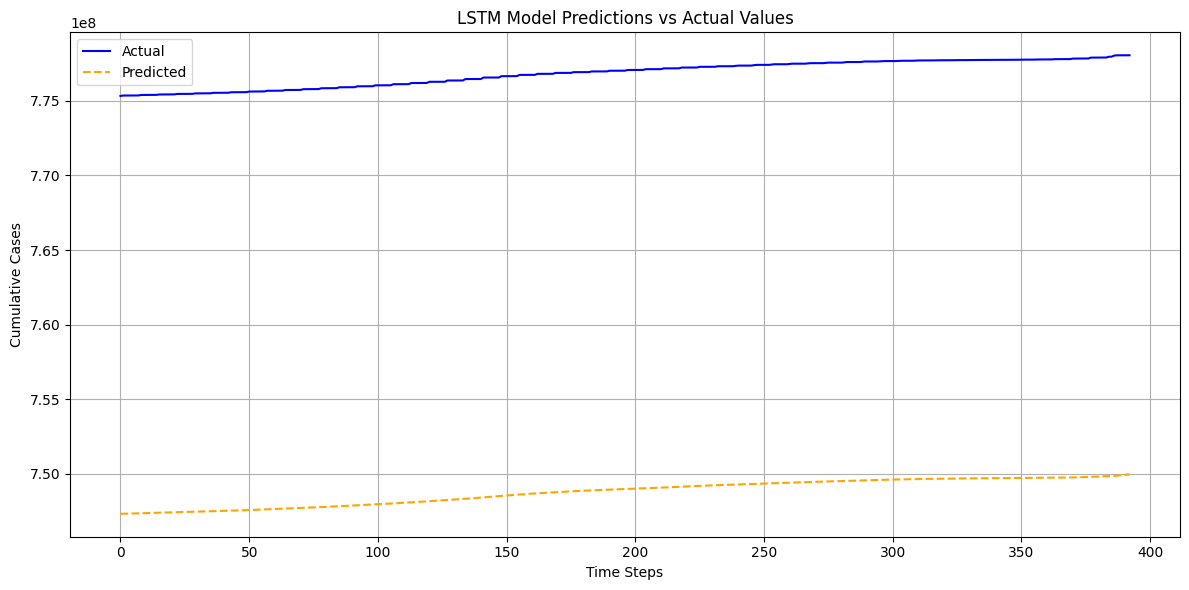

(786900927475803.5, 28051741.872773536)

In [30]:


# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='orange', linestyle='--')
plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

mse, mae

# Comparing Models on Each Country and Aggregate by WHO region

In [31]:

# Initialize a dictionary to store results for each country
model_comparison = []

# Iterate over each country
for country in who_covid_data['Country'].unique():
    country_data = who_covid_data[who_covid_data['Country'] == country]

    # Prepare data for ARIMA
    arima_series = country_data.groupby('Date_reported')['Cumulative_cases'].sum()
    
    # Prepare data for Prophet
    prophet_data = arima_series.reset_index()
    prophet_data.columns = ['ds', 'y']

    # Prepare data for LSTM
    cases = arima_series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    cases_scaled = scaler.fit_transform(cases)
    window_size = 14
    X, y = [], []
    for i in range(len(cases_scaled) - window_size):
        X.append(cases_scaled[i:i + window_size, 0])
        y.append(cases_scaled[i + window_size, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Store the prepared data for aggregation by region
    model_comparison.append({
        'Country': country,
        'WHO_region': country_data['WHO_region'].iloc[0],
        'ARIMA_series': arima_series,
        'Prophet_data': prophet_data,
        'LSTM_train': (X_train, y_train),
        'LSTM_test': (X_test, y_test)
    })

# Aggregate by WHO region
region_aggregation = {}
for entry in model_comparison:
    region = entry['WHO_region']
    if region not in region_aggregation:
        region_aggregation[region] = []
    region_aggregation[region].append(entry)

region_aggregation

{'AMR': [{'Country': 'Saint Vincent and the Grenadines',
   'WHO_region': 'AMR',
   'ARIMA_series': Date_reported
   2020-01-04       0
   2020-01-05       0
   2020-01-06       0
   2020-01-07       0
   2020-01-08       0
                 ... 
   2025-05-28    9674
   2025-05-29    9674
   2025-05-30    9674
   2025-05-31    9674
   2025-06-01    9674
   Name: Cumulative_cases, Length: 1976, dtype: int64,
   'Prophet_data':              ds     y
   0    2020-01-04     0
   1    2020-01-05     0
   2    2020-01-06     0
   3    2020-01-07     0
   4    2020-01-08     0
   ...         ...   ...
   1971 2025-05-28  9674
   1972 2025-05-29  9674
   1973 2025-05-30  9674
   1974 2025-05-31  9674
   1975 2025-06-01  9674
   
   [1976 rows x 2 columns],
   'LSTM_train': (array([[[0.],
            [0.],
            [0.],
            ...,
            [0.],
            [0.],
            [0.]],
    
           [[0.],
            [0.],
            [0.],
            ...,
            [0.],
       

The models have been compared for each country and aggregated by WHO region.

# Forecasting using lSTM for top 20 Countries

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


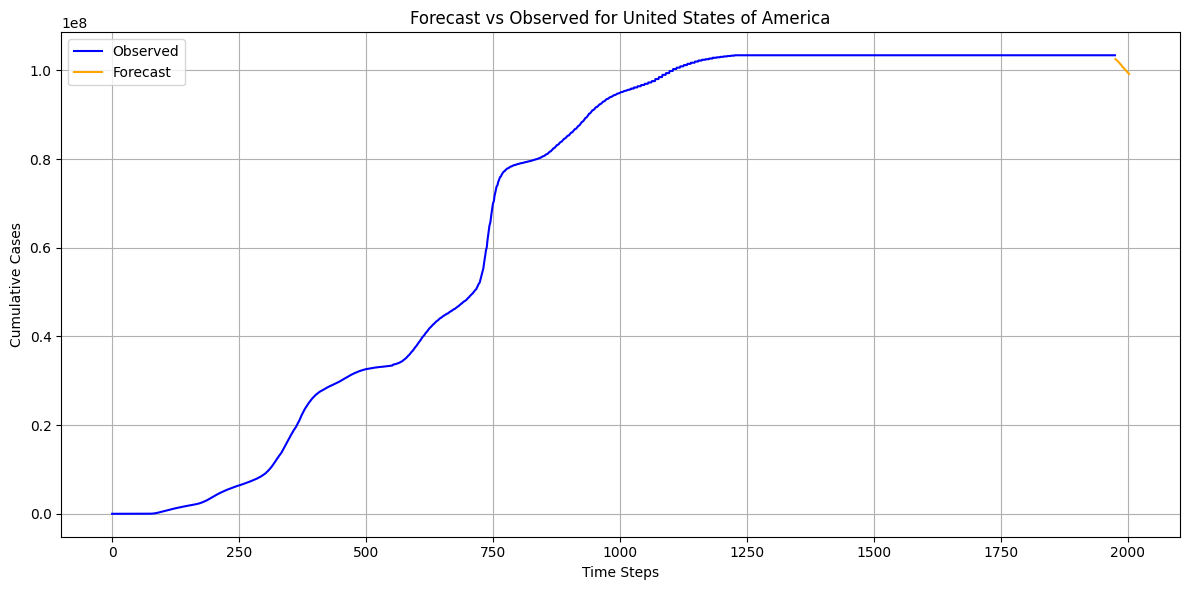

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


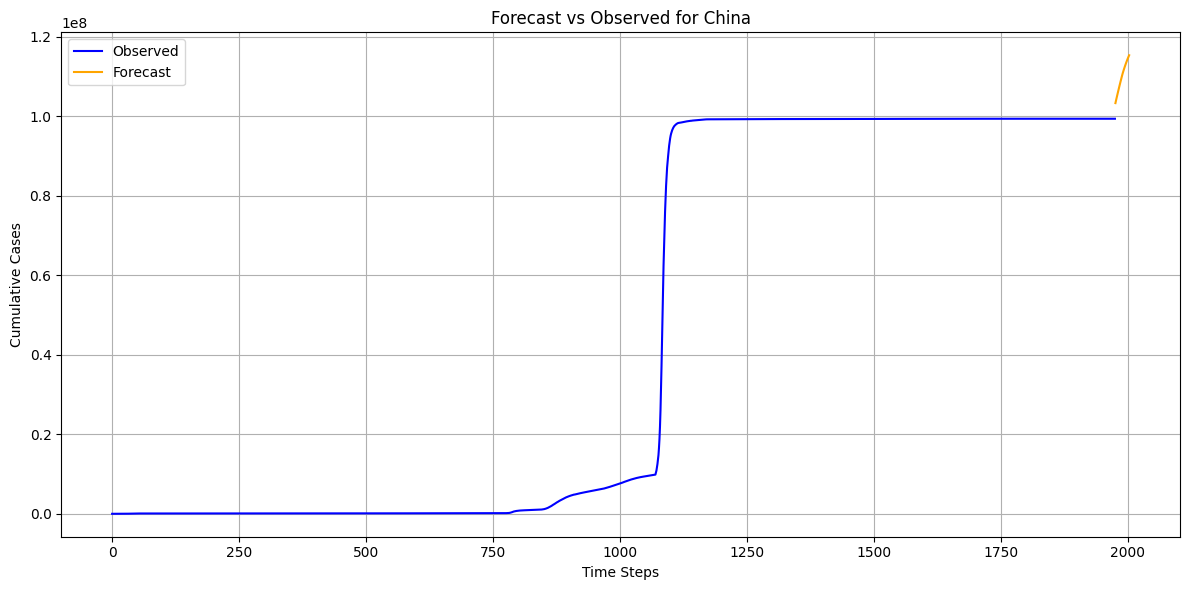

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


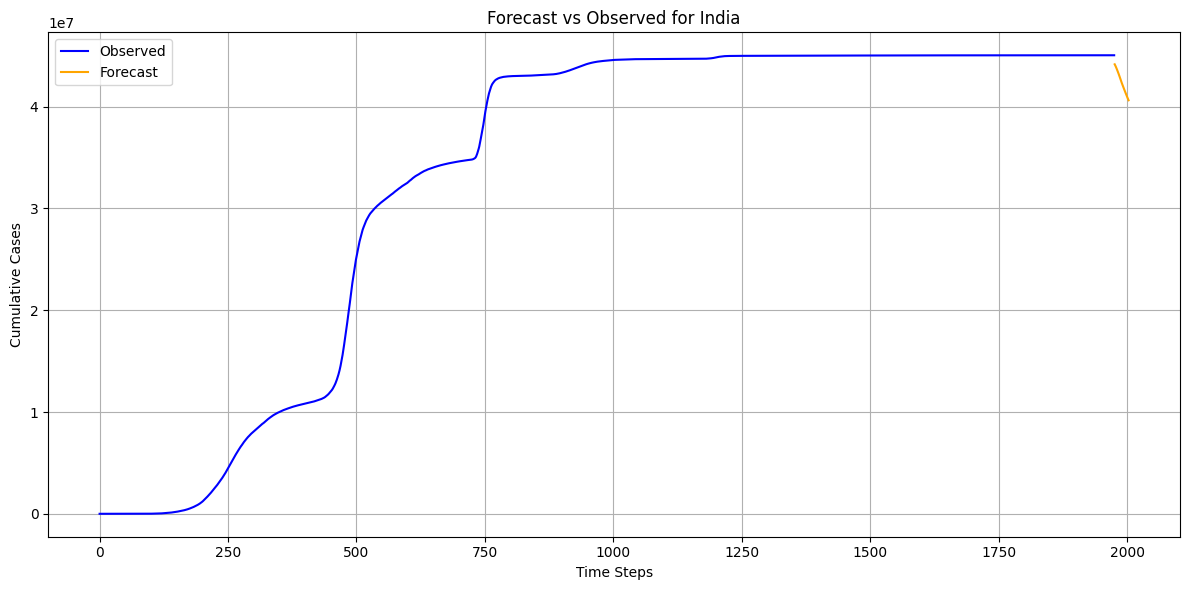

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


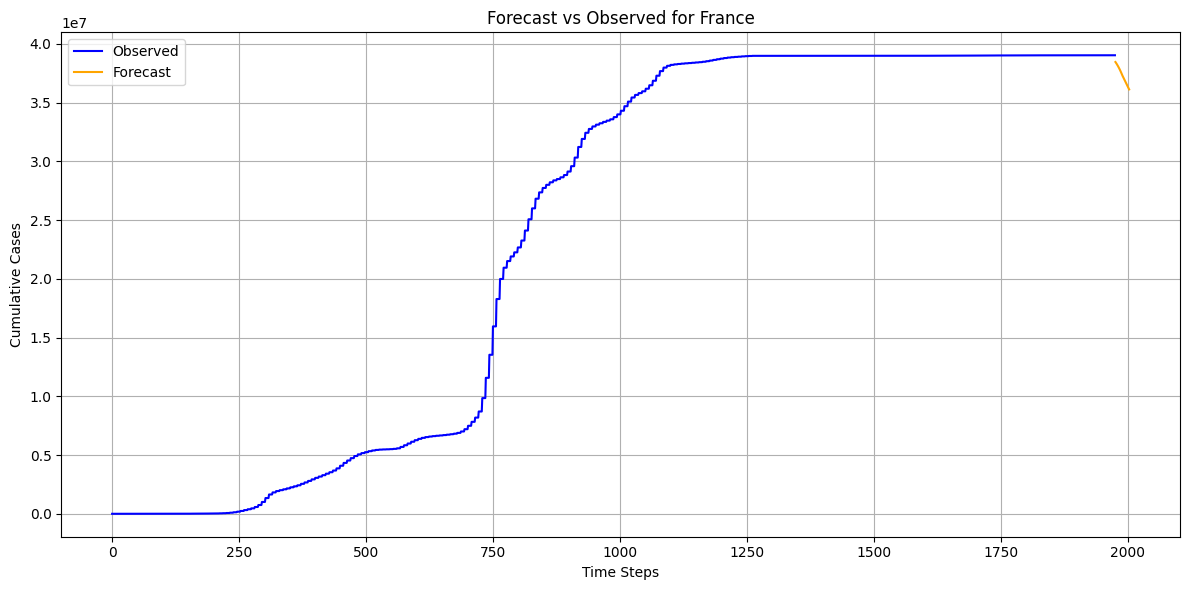

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


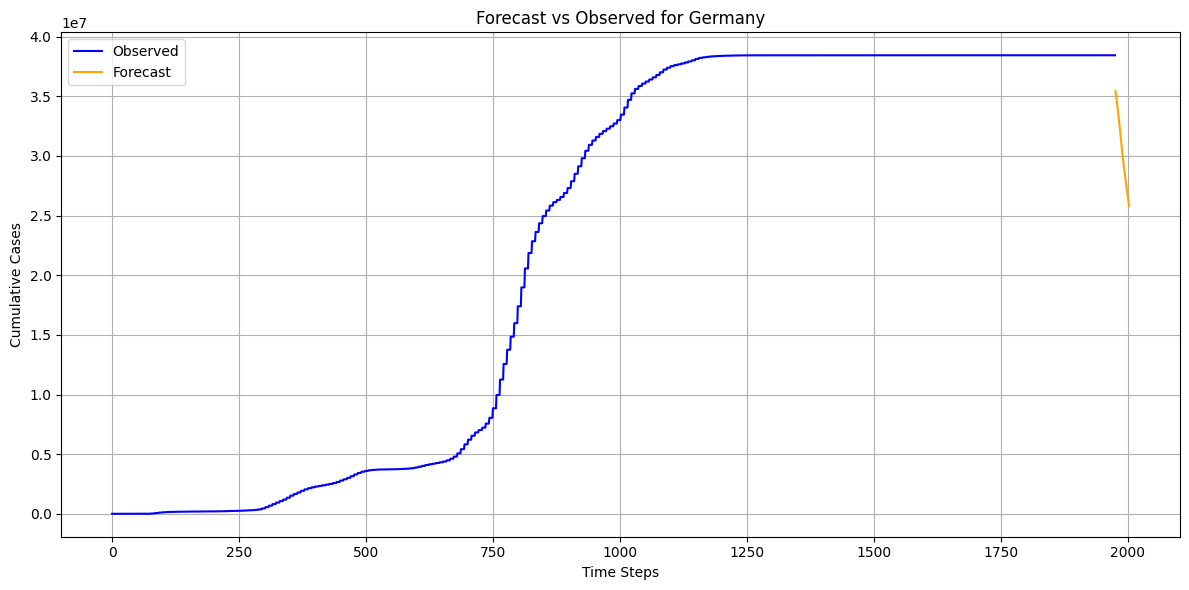

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


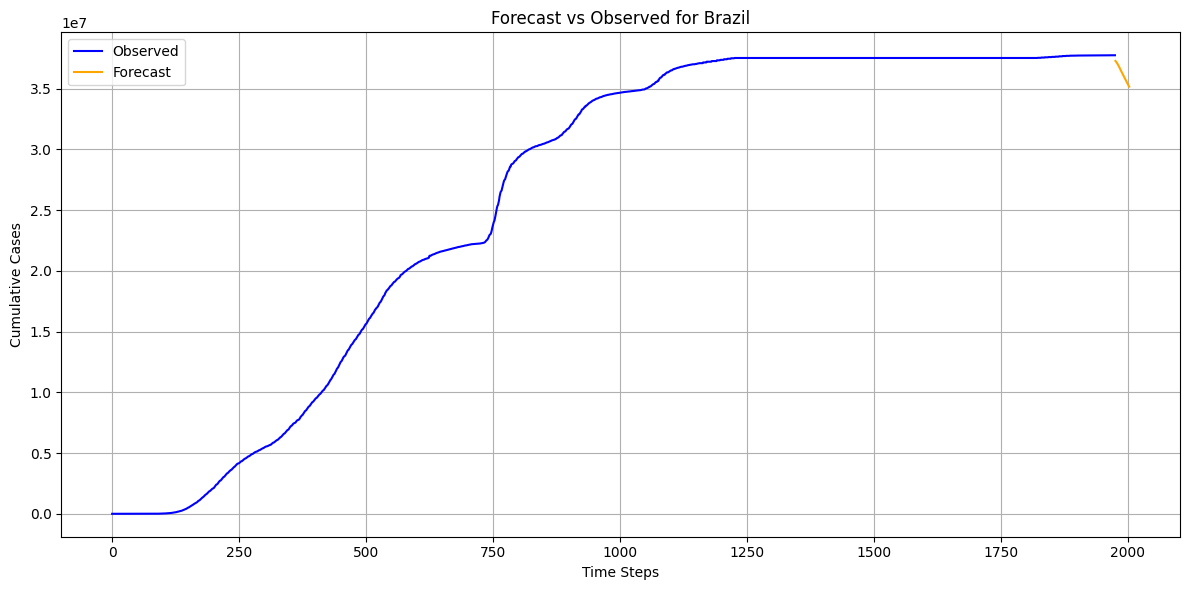

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


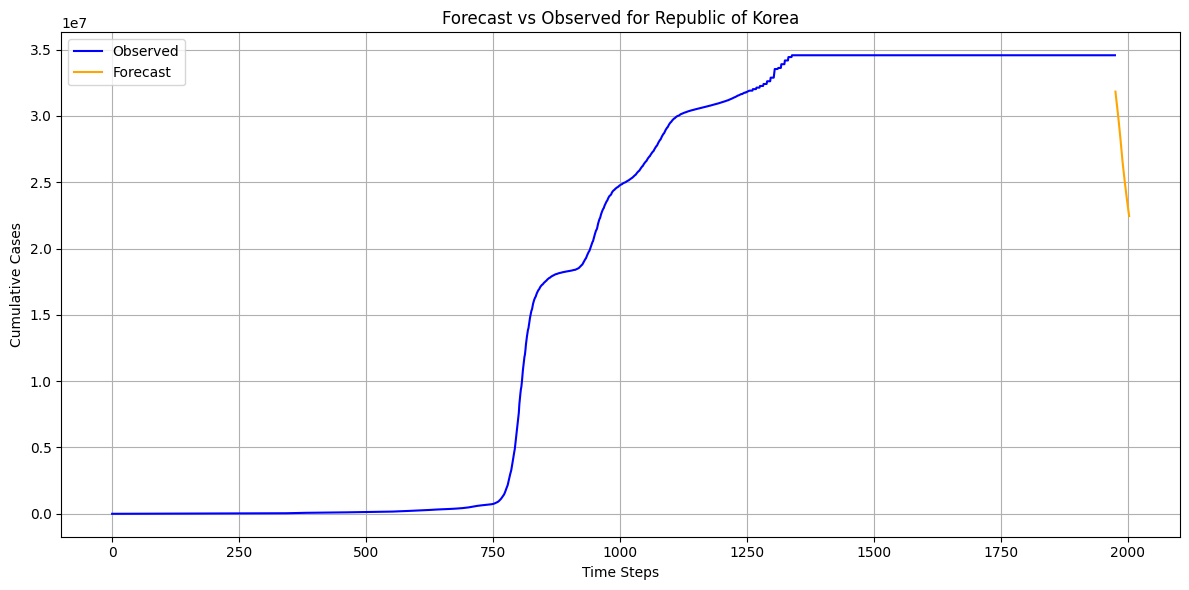

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


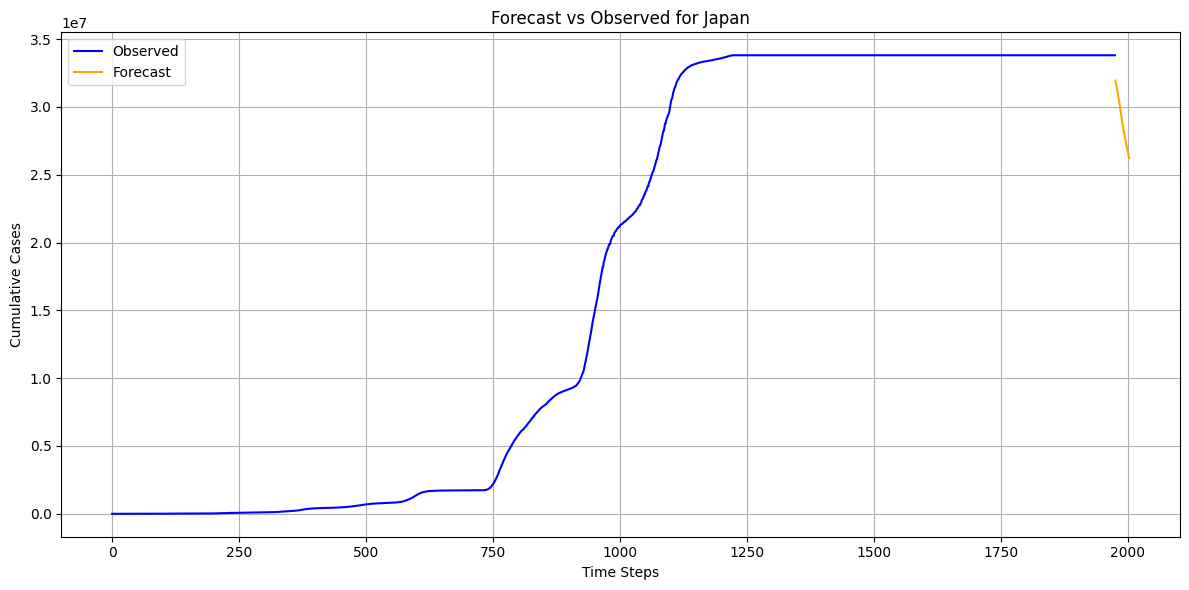

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


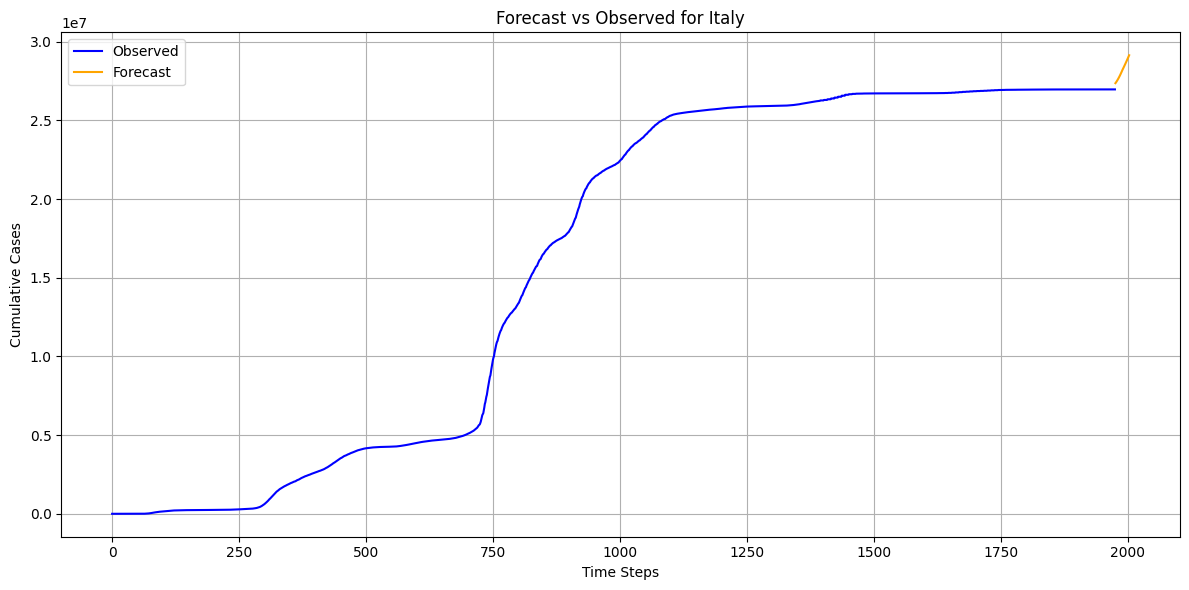

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


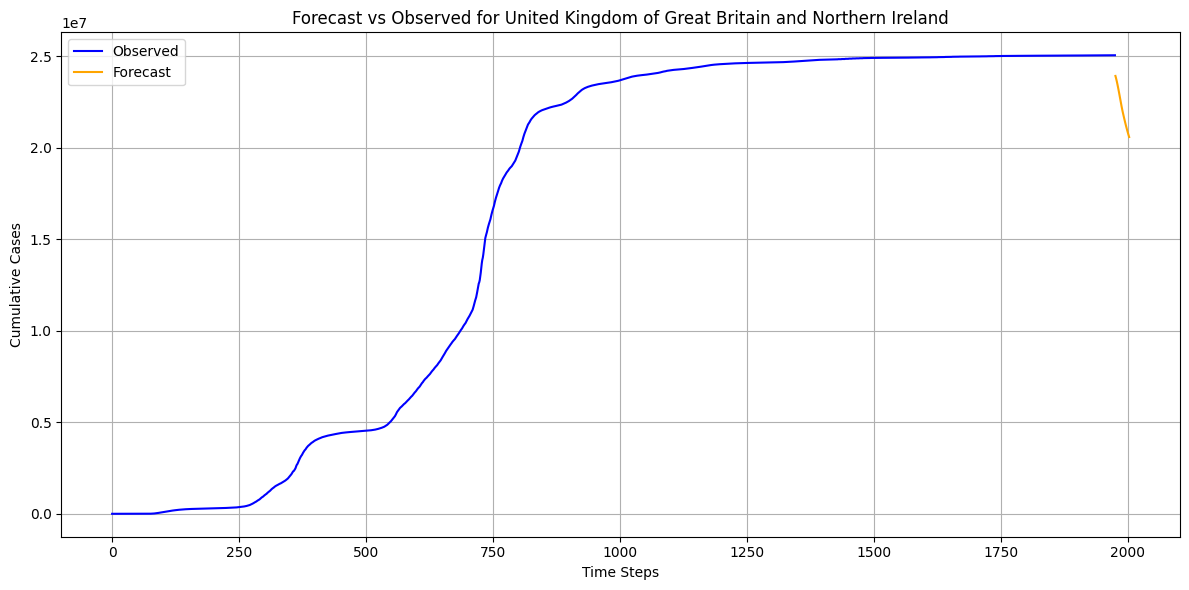

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


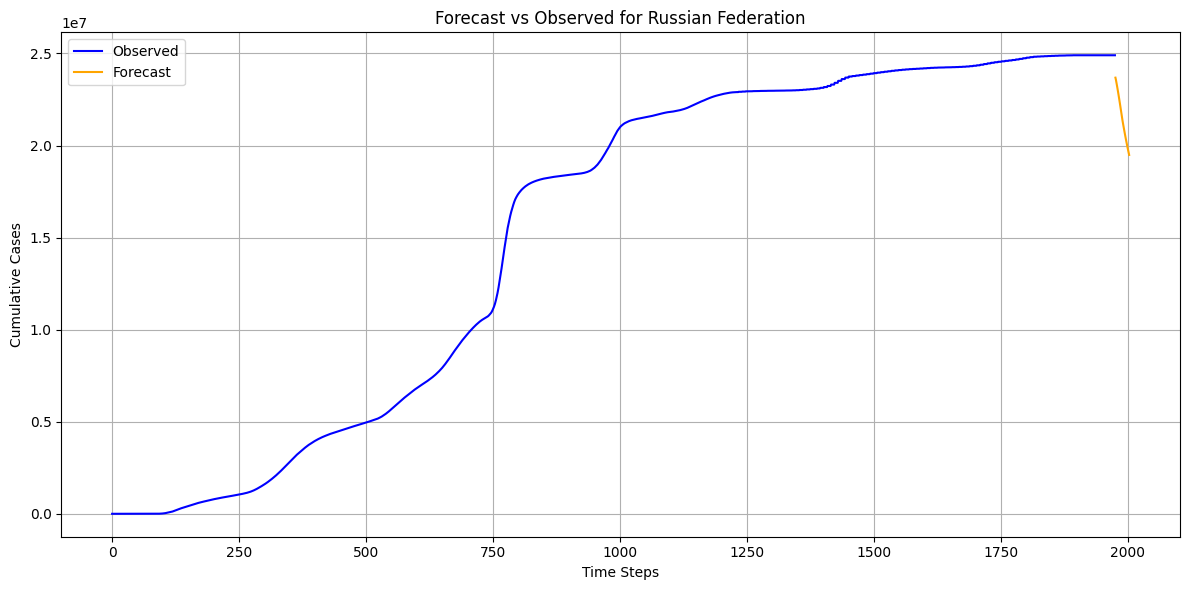

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


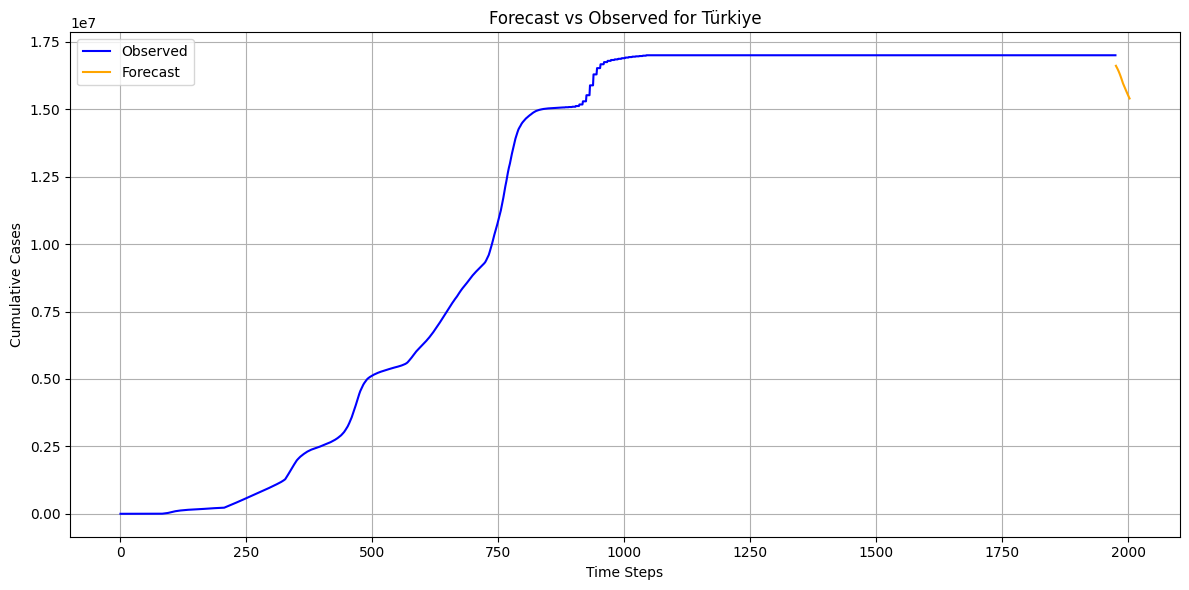

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


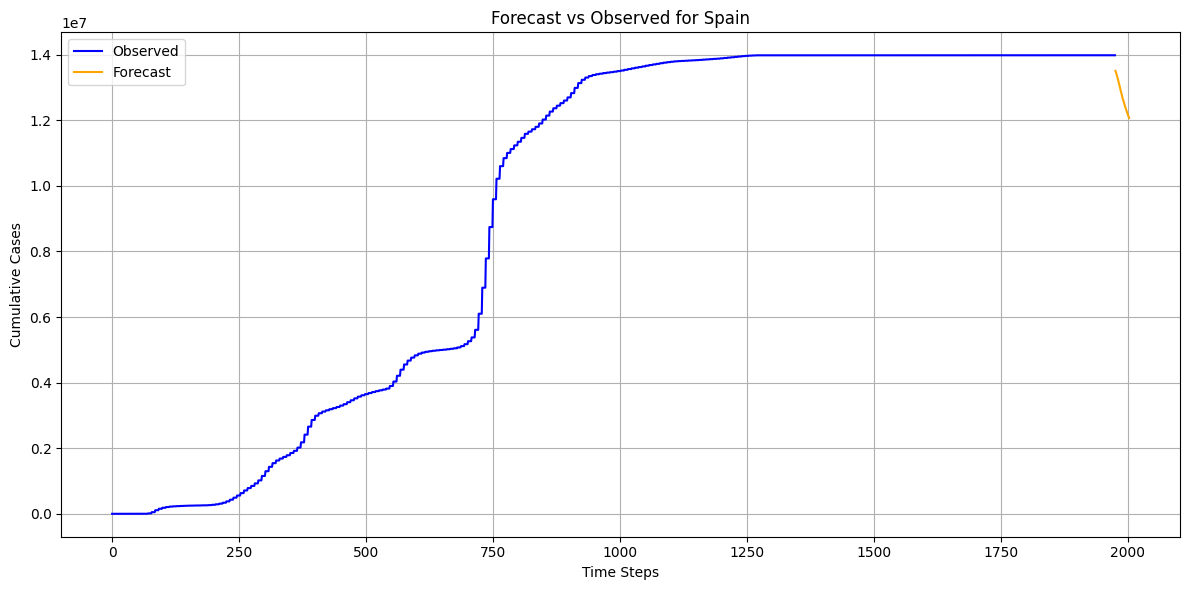

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


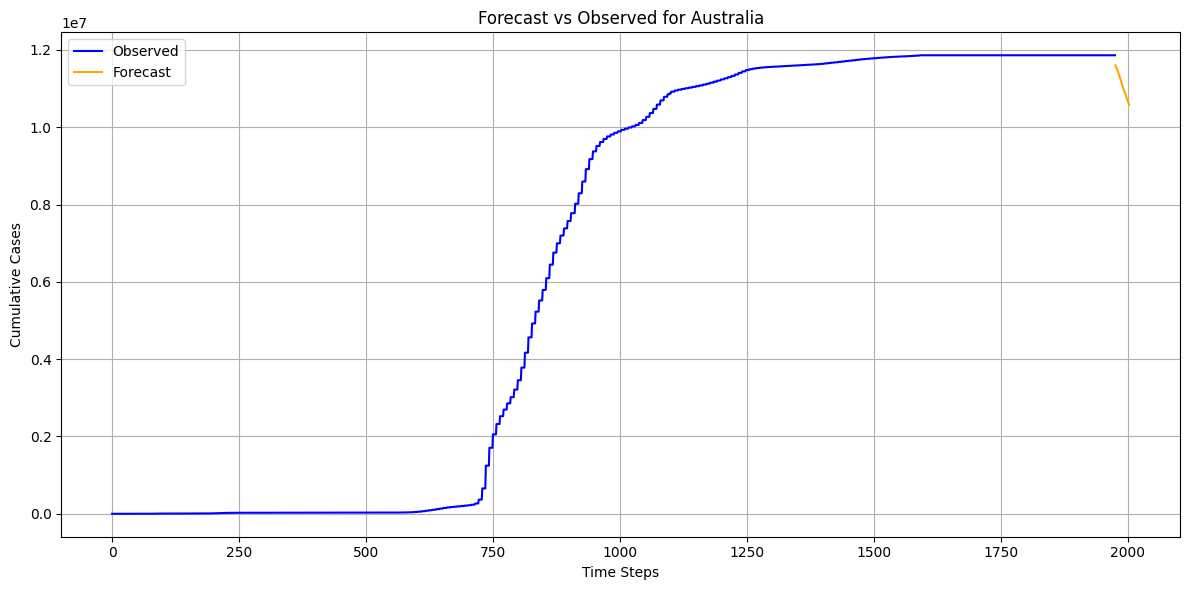

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


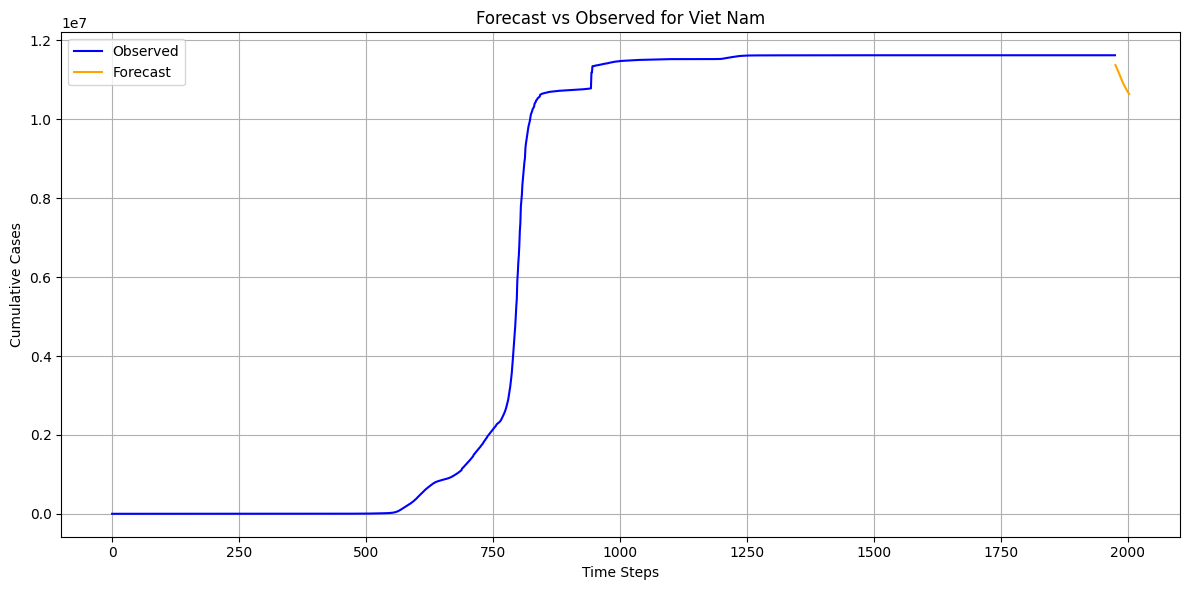

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


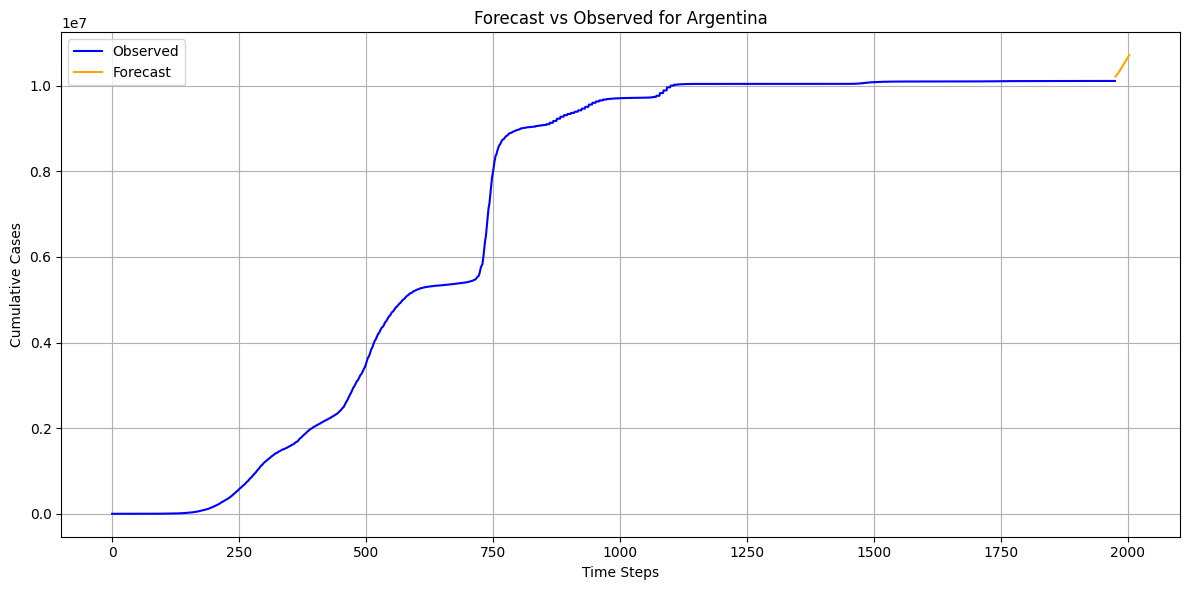

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


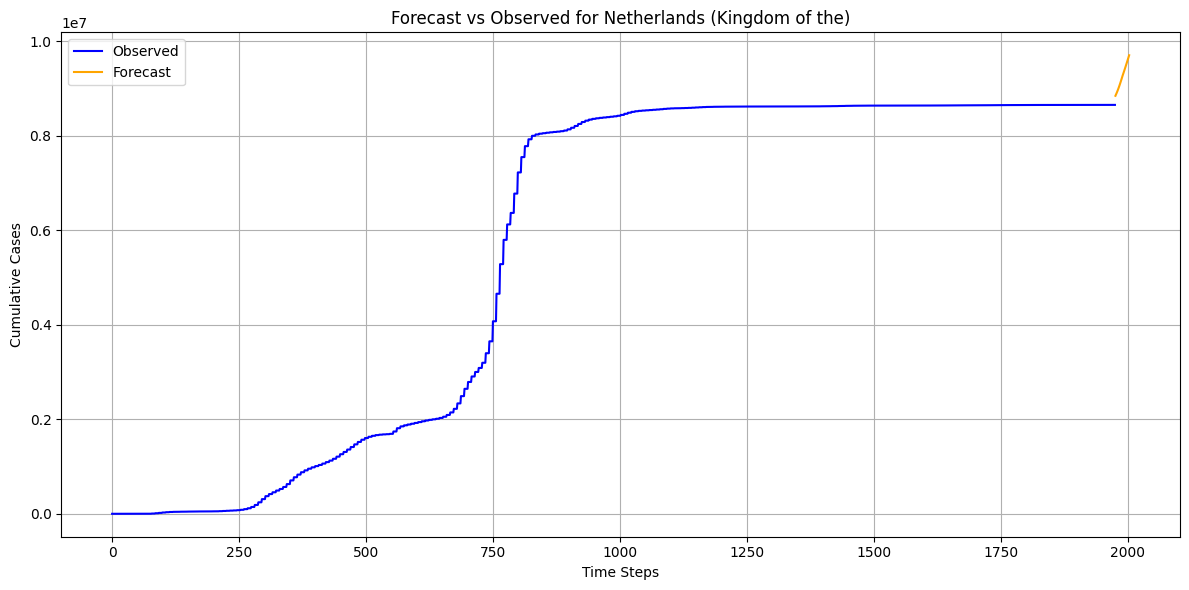

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


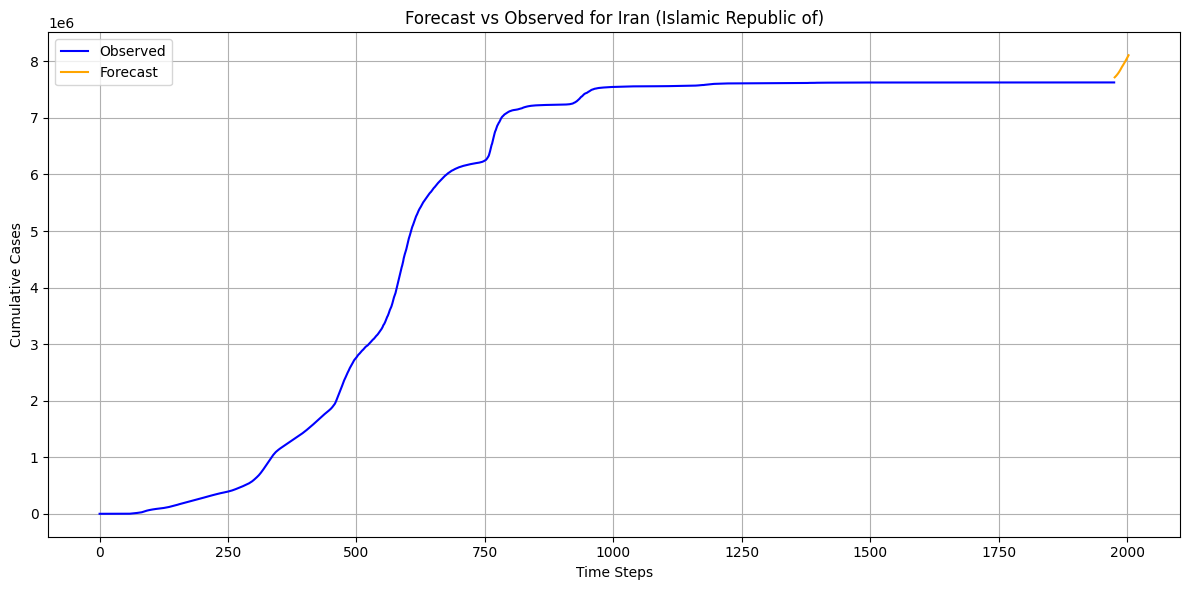

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


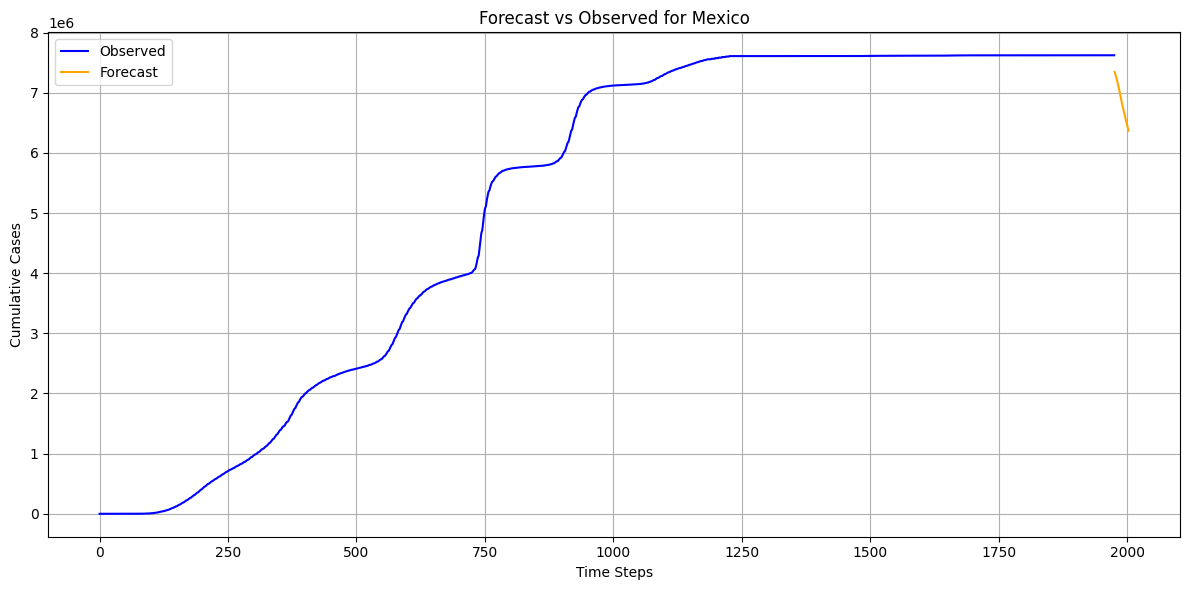

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


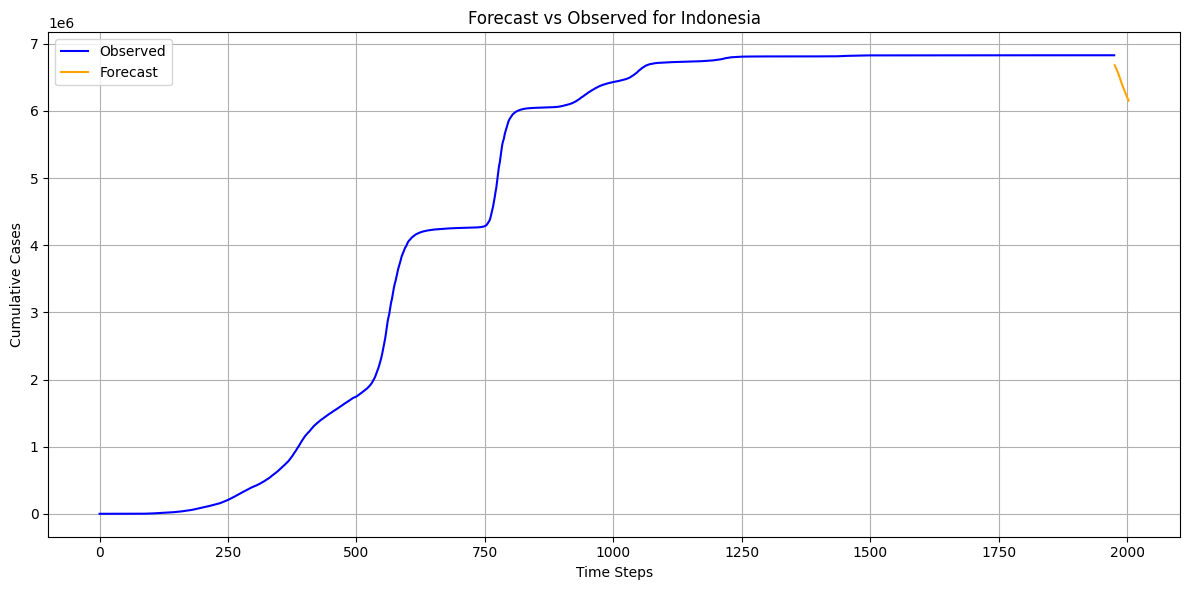

In [32]:
# Function to generate 14- and 28-day ahead forecasts using LSTM
# and visualize forecasts versus observed values for the top 20 countries by cases and deaths
def generate_lstm_forecasts_top20(country_data, window_size=14, forecast_horizon=28):
    forecasts = {}

    # Filter top 20 countries by cumulative cases and deaths
    top_countries = country_data.groupby('Country')[['Cumulative_cases', 'Cumulative_deaths']].max()
    top_countries = top_countries.sort_values(by=['Cumulative_cases', 'Cumulative_deaths'], ascending=False).head(20).index

    for country in top_countries:  # Limit to top 20 countries
        country_df = country_data[country_data['Country'] == country]
        cases = country_df['Cumulative_cases'].values.reshape(-1, 1)

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        cases_scaled = scaler.fit_transform(cases)

        # Prepare sliding windows
        X, y = [], []
        for i in range(len(cases_scaled) - window_size):
            X.append(cases_scaled[i:i + window_size, 0])
            y.append(cases_scaled[i + window_size, 0])
        X, y = np.array(X), np.array(y)

        # Reshape X to be [samples, time steps, features]
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # Split into training and testing sets
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Train LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

        # Generate forecasts
        last_window = cases_scaled[-window_size:]
        forecast = []
        for _ in range(forecast_horizon):
            pred = model.predict(last_window.reshape(1, window_size, 1), verbose=0)
            forecast.append(pred[0, 0])
            last_window = np.append(last_window[1:], pred, axis=0)

        # Inverse transform the forecast
        forecast_rescaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

        # Store results
        forecasts[country] = {
            'forecast': forecast_rescaled.flatten(),
            'observed': cases[-forecast_horizon:].flatten() if len(cases) >= forecast_horizon else cases.flatten()
        }

        # Visualize
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(cases)), cases, label='Observed', color='blue')
        plt.plot(range(len(cases), len(cases) + forecast_horizon), forecast_rescaled, label='Forecast', color='orange')
        plt.title(f'Forecast vs Observed for {country}')
        plt.xlabel('Time Steps')
        plt.ylabel('Cumulative Cases')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

    return forecasts

# Generate forecasts for the top 20 countries by cases and deaths
lstm_forecasts_top20 = generate_lstm_forecasts_top20(who_covid_data)